## unet

In [26]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as F

class DoubleConv (nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        return self.conv(x)

class Unet (nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64,128,256,512]) -> None:
        super(Unet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # down
        for feature in features:
            self.downs.append(DoubleConv(in_channels=in_channels, out_channels=feature))
            in_channels = feature

        # up
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(in_channels=feature*2, out_channels=feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature*2, feature))

        # bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_conn = []
        for down in self.downs:
            x = down(x)
            skip_conn.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_conn = skip_conn[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_conn[idx//2]

            if x.shape != skip.shape:
                x = F.resize(x, size=skip.shape[2:])

            concat_skip = torch.cat((skip, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


## test

In [27]:
x = torch.rand([3, 1, 161, 161])
unet = Unet(1,1)
print(unet(x).shape)

torch.Size([3, 1, 161, 161])


## data

In [28]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

class CarvanaDataset (Dataset):
    def __init__(self, image_dir, mask_dir, transform=None) -> None:
        super(CarvanaDataset, self).__init__()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace('.jpg', '_mask.gif'))
        image = np.array(Image.open(img_path).convert('RGB'))
        mask = np.array(Image.open(mask_path).convert('L'), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentation = self.transform(image=image, mask=mask)
            image = augmentation['image']
            mask = augmentation['mask']

        return (image, mask)

In [4]:
from torch.utils.data import DataLoader

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=0,
):
    train_ds = CarvanaDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True,
    )

    val_ds = CarvanaDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
    )

    return train_loader, val_loader


## train

In [29]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

In [30]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
from tqdm import tqdm

print(f'CUDA available: {torch.cuda.is_available()}')

lr = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 8
epochs = 5
height = 160
width = 240

train_transform = A.Compose(
        [
            A.Resize(height=height, width=width),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

val_transform = A.Compose(
        [
            A.Resize(height=height, width=width),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

unet = Unet(in_channels=3, out_channels=1).to(device)
loss_f = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(unet.parameters(), lr=lr)

train_loader, val_loader = get_loaders(
    './carvana/train/',
    './carvana/train_masks/',
    './carvana/val/',
    './carvana/val_masks/',
    batch_size,
    train_transform,
    val_transform
)

scaler = torch.cuda.amp.GradScaler()

for epoch in range(epochs):
    loop = tqdm(train_loader)
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device)
        targets = targets.float().unsqueeze(1).to(device)

        # forward
        #with torch.cuda.amp.autocast():
        predictions =  unet(data)
        loss = loss_f(predictions, targets)
        
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # update tqdm
        loop.set_postfix(loss=loss.item())

    check_accuracy(val_loader, unet, device)

CUDA available: True


100%|██████████| 626/626 [11:17<00:00,  1.08s/it, loss=0.0919]


Got 3050529/3072000 with acc 99.30
Dice score: 0.9828733801841736


100%|██████████| 626/626 [11:19<00:00,  1.08s/it, loss=0.0429]


Got 3052375/3072000 with acc 99.36
Dice score: 0.984408974647522


100%|██████████| 626/626 [11:20<00:00,  1.09s/it, loss=0.0274]


Got 3056397/3072000 with acc 99.49
Dice score: 0.9875256419181824


100%|██████████| 626/626 [11:23<00:00,  1.09s/it, loss=0.0197]


Got 3056842/3072000 with acc 99.51
Dice score: 0.9877811670303345


100%|██████████| 626/626 [11:26<00:00,  1.10s/it, loss=0.0197]


Got 3057399/3072000 with acc 99.52
Dice score: 0.9881884455680847


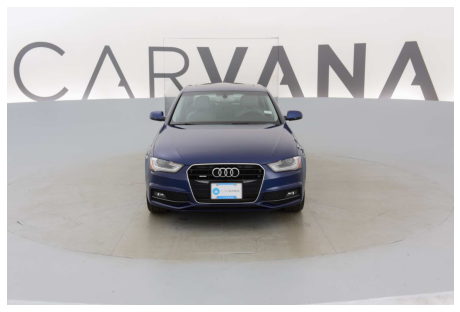

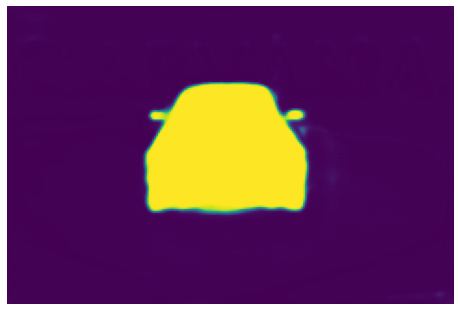

In [36]:
import matplotlib.pyplot as plt

image = np.array(Image.open('./carvana/val/0cdf5b5d0ce1_01.jpg').convert('RGB'))
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.show()
image = val_transform(image=image)['image']
image = image.unsqueeze(0).to(device)
pred = torch.sigmoid(unet(image))
pred = pred.squeeze().squeeze().to('cpu').detach().numpy()
plt.figure(figsize=(8, 8))
plt.imshow(pred)
plt.axis('off')
plt.show()